In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from simple_detector import *
from advanced_detector import CameraPipeline

In [39]:
import logging
logging.basicConfig()
format_ = '%(asctime) - %(message)s'
logger = logging.getLogger('test')
logger.setLevel(logging.DEBUG)

In [40]:
# calibration n test cases
calibration_folder = 'camera_cal'
test_cases = 'test_images'

# Testing

In [41]:
from advanced_detector import hls_select
test_set = glob.glob(test_cases + '/*.jpg')

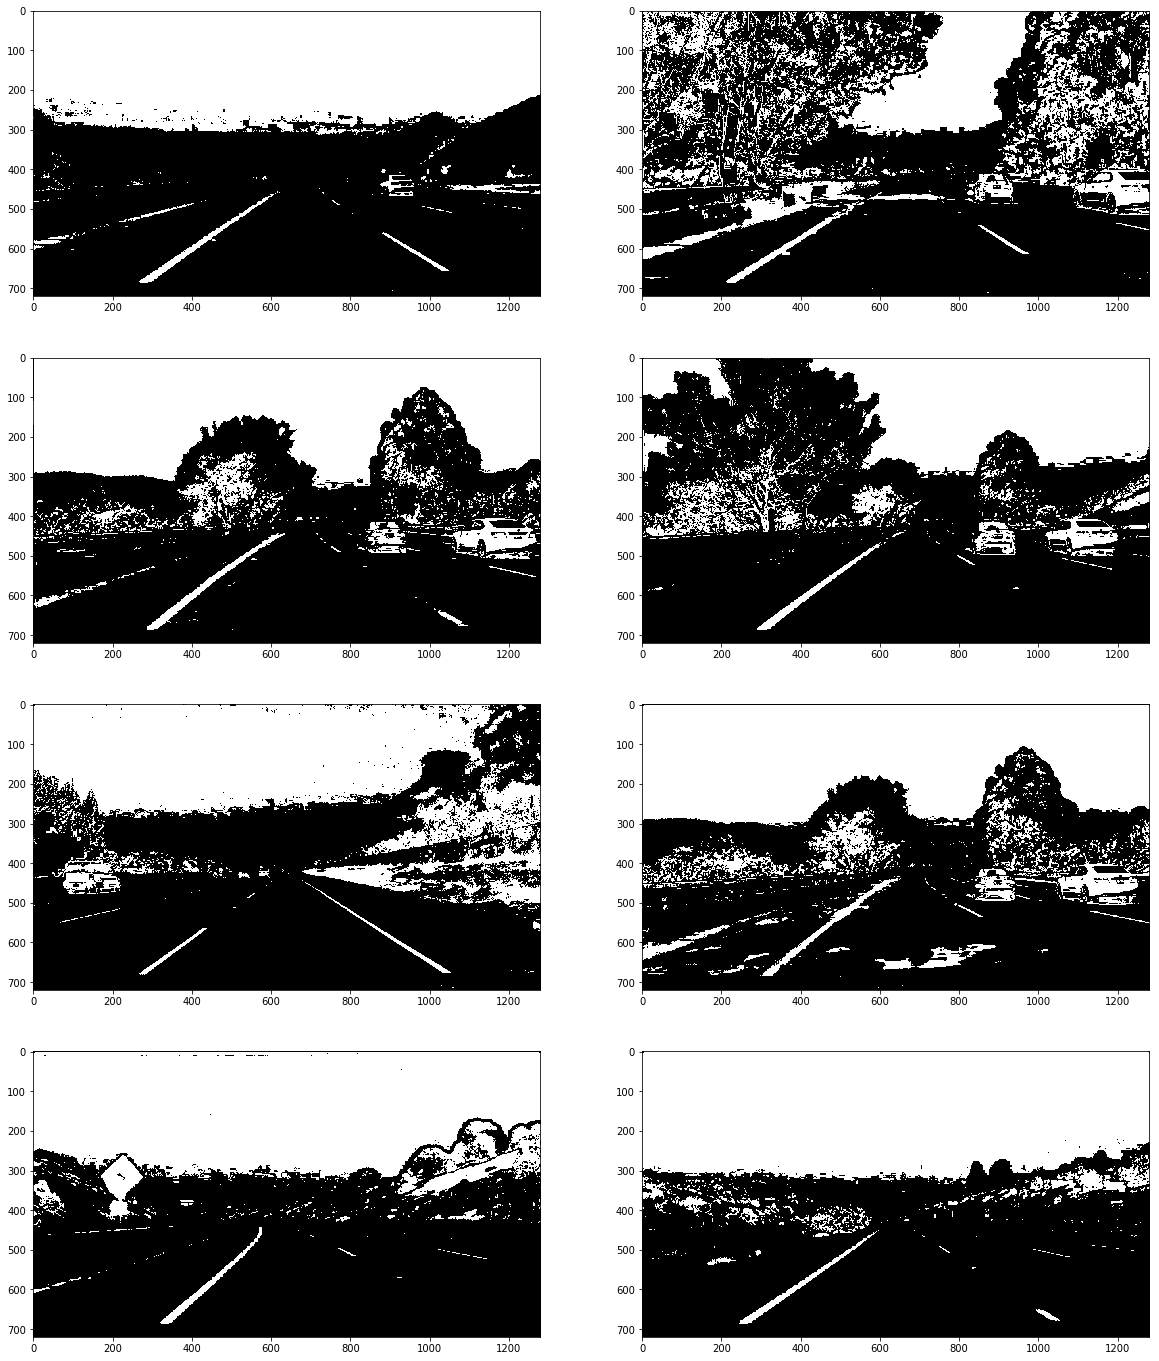

In [42]:
# check filtering

test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
for i in range(0, test_length):

    img, img_size = read_video(test_set[i])
    R = img[:,:, 0]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    thresh = (215, 255)
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    thresh = (90, 255)
    binary_2 = np.zeros_like(S)
    binary_2[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    merg = np.zeros_like(S)
    merg[(binary == 1) | (binary_2 == 1)]=1
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(merg, cmap='gray', interpolation='none')

In [43]:
def testing_pipeline(img_path, how_far_down):
    
    result, fr_shape = read_video(img_path)
    
    hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    
    #proc_f = grayscale(result)
    proc_f = gaussian_blur(S, 5)
    proc_f = canny(proc_f, 30, 255)
    roi = region_of_interest(proc_f, np.array([[(0.1*fr_shape[1],fr_shape[0]),
                                            (fr_shape[1]*0.95, fr_shape[0]), 
                                            (0.55*fr_shape[1], how_far_down*fr_shape[0]), 
                                            (0.45*fr_shape[1],how_far_down*fr_shape[0])]], dtype=np.int32))
    proc_f_lines = hough_lines(roi, 4, np.pi/180, 16, 5, 400)
    if proc_f_lines is not None:
        final_lines = find_lines(proc_f, proc_f_lines)
        #logger.debug('{0} lines'.format(final_lines))
    
        corner_points = find_points_for_transform(final_lines, result)
        logger.debug('image:{0} corner points:{1}'.format(img_path, corner_points))
        
        output_img = draw_lines(proc_f, final_lines, margin = 90)
        output_img = weighted_img(output_img, result)

    else:
        output_img = result
        
    return output_img, corner_points

DEBUG:test:image:test_images/test5.jpg corner points:[[227, 687, 585, 468], [910, 574, 973, 613]]


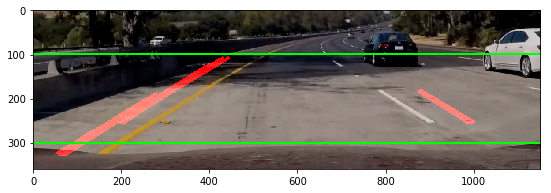

In [44]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
side_margin = 0.05
for i in range(1, 2):

    output_img, corners = testing_pipeline(test_set[i], hfd)
    
    output_shape = output_img.shape
    
    car_forward_region = output_img[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
    
    cv2.line(car_forward_region, (0,100),(car_forward_region.shape[1],100),[0,255,0], 3)
    cv2.line(car_forward_region, (0,300),(car_forward_region.shape[1],300),[0,255,0], 3)
    
    #cv2.line(car_forward_region, (900,0),(900, car_forward_region.shape[0]),[0,255,0], 3)
    #cv2.line(car_forward_region, (1050,0),(1050, car_forward_region.shape[0]),[0,255,0], 3)
    
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(car_forward_region, cmap='gray', interpolation='none')

In [45]:
# it's not working right but lets do the perspective transform and other bits first
img_size = car_forward_region.shape

#src = np.float32([[395, 180], [820, 180], [180,300], [1100,300]])
#dst = np.float32([[190, 180], [1055, 180], [180,300], [1100,300]])

src = np.float32([[445, 150], [760, 150], [150,300], [1100,300]])
dst = np.float32([[190, 150], [1055, 150], [150,300], [1100,300]])

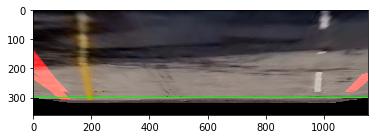

In [46]:
# hardcoded perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(car_forward_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 

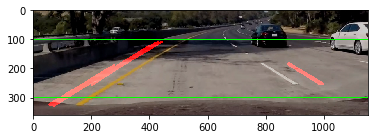

In [47]:
plt.imshow(car_forward_region, cmap='gray') 

# Distort and run the window on merged image

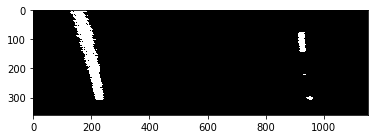

In [48]:
merged_car_region = merg[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
img_size = merged_car_region.shape
warped = cv2.warpPerspective(merged_car_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 

In [49]:
# try exercise code
from advanced_detector import find_lane_pixels, fit_polynomial

In [50]:
left_fit, right_fit, left_fit_pts, right_fit_pts, ploty = fit_polynomial(warped)
#plt.imshow(out_img)

In [51]:
left = list(zip(left_fit_pts, ploty))
right = list(zip(right_fit_pts, ploty))
left = np.array(left).tolist()
right = np.array(right).tolist()

cv2ordered_lines = []
cv2ordered_lines.append(left.pop(0))

cv2ordered_lines.extend(right)

cv2ordered_lines.extend(left[::-1])


(720, 2)


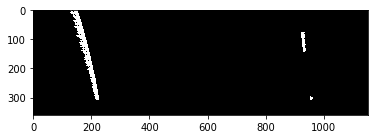

In [52]:
### testing
import matplotlib.pyplot as plt
# [[200, 0],  [1000, 0], [1000, 300], [200, 300]]

arrayit = np.array(cv2ordered_lines ,dtype=np.int32)
print(arrayit.shape)
result = cv2.fillPoly(warped, np.int32([arrayit]), (0, 255, 0) )

plt.imshow(result, cmap='gray')
#plt.show()


In [53]:
# cannot plot polygon for now...
#lfp = left_fit_pts.astype('int')
#rfp = right_fit_pts.astype('int')
#plotf = ploty.astype('int')

#zt = list(zip(lfp, plotf))
#zt.append(list(zip(rfp, plotf)))
##zt2 = np.array([np.array(z) for z in zt])
#zt2=np.array(zt)
#zt2 = zt2.reshape((-1,1,2))
#zt3 = cv2.polylines(out_img, [zt2],True,(0,255,255))

In [54]:
# curvature estimate
def measure_curvature_pixels(warped_img, left_fit, right_fit):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(warped_img)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [55]:
#measure_curvature_pixels(warped, left, right)

# Calibrate Image First

In [56]:
cal_images = glob.glob(calibration_folder + '/*.jpg')

In [57]:
process_cam = CameraPipeline(9,6)
process_cam.calibrate_cam(cal_images)

# Run on Test

In [58]:
test_set = glob.glob(test_cases + '/*.jpg')

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


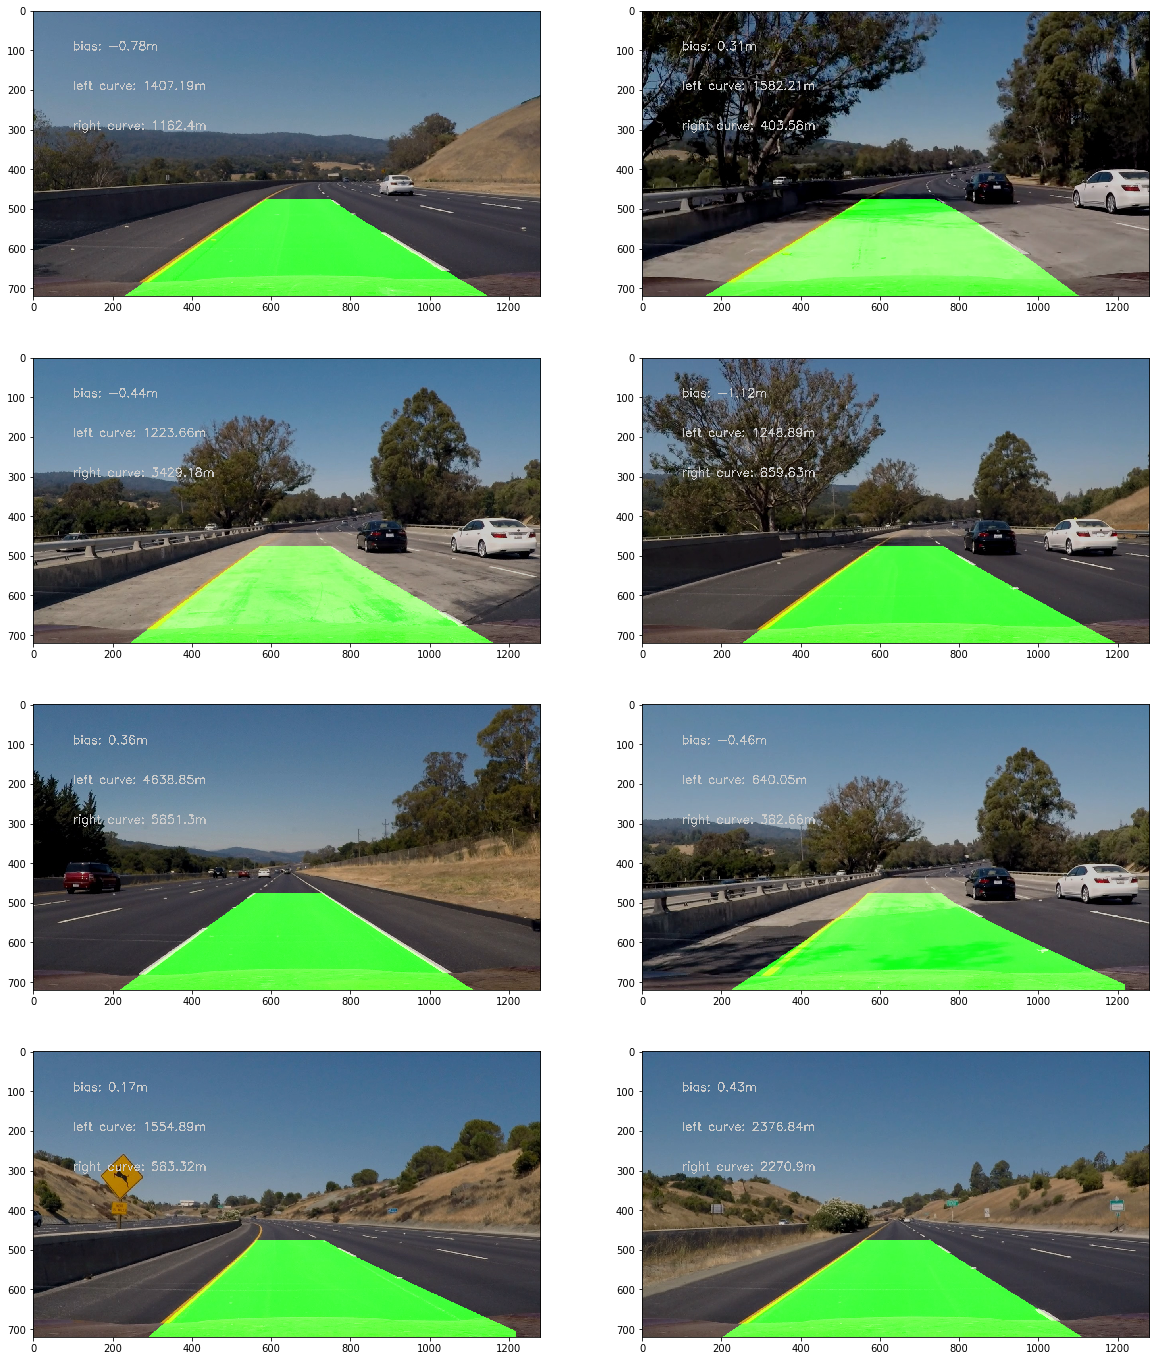

In [59]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
for i in range(0, test_length):
    #logger.info(print(test_pack[i]))
    result = process_cam.process(test_set[i])    
    
    print(result.shape)
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(result, cmap='gray', interpolation='none')

# Test on Video

In [60]:
def process_image(image):
    result = process_cam.process_image(image)
    return result

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
output = 'project_processed_video.mp4'
clip = VideoFileClip('project_video.mp4')

In [63]:
test = process_cam.process('project_video.mp4')    

In [64]:
type(test)

numpy.ndarray

In [65]:

image_clip = clip.fl_image(process_image)
%time image_clip.write_videofile(output, audio=False)


t:   0%|          | 5/1260 [00:00<00:29, 43.01it/s, now=None]

Moviepy - Building video project_processed_video.mp4.
Moviepy - Writing video project_processed_video.mp4



Moviepy - Done !
Moviepy - video ready project_processed_video.mp4
CPU times: user 4min 28s, sys: 6.44 s, total: 4min 34s
Wall time: 32 s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))